In [2]:
# @title
!pip install torch torchvision numpy matplotlib pandas scipy pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import time as time
import torchvision.transforms as T
import torchvision.datasets as datasets
import tempfile
import multiprocessing


In [6]:
!pip install pytorch-fid

In [7]:
try:
    import kagglehub
    kushsheth_face_vae_path = kagglehub.dataset_download('kushsheth/face-vae')
    print('Data source import complete.')
except ImportError:
    print("kagglehub not found. Assuming local setup for data paths.")
    # Fallback for local development: Adjust these paths if running locally
    # For local setup, ensure you download the CelebA dataset and list_attr_celeba.csv
    # to these relative paths or specify absolute paths.
    kushsheth_face_vae_path = './data/face-vae' # Example local path
    if not os.path.exists(kushsheth_face_vae_path):
        print("Local data path not found. Please ensure CelebA dataset is available at expected location.")

Data source import complete.


In [8]:
# Hyperparameters
batch_size = 128
epochs = 50
latent_dim = 256
learning_rate = 1e-3
image_size = 128  # Using 64x64 for faster training, FFHQ is typically 1024x1024
channels = 3

In [9]:
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_path, transform=None, target_attr=None):

        self.img_dir = img_dir
        self.attributes = pd.read_csv(attr_path)
        self.transform = transform
        self.target_attr = target_attr

    def __len__(self):
        return len(self.attributes)

    def __getitem__(self, idx):
        img_name = self.attributes.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        if self.target_attr:

            attr_label = self.attributes.iloc[idx][self.target_attr]
            attr_label = 0 if attr_label == -1 else 1
            return image, attr_label
        else:
            return image

In [10]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

img_dir = "/kaggle/input/face-vae/img_align_celeba/img_align_celeba"
attr_path = "/kaggle/input/face-vae/list_attr_celeba.csv"

dataset = CelebADataset(
    img_dir=img_dir,
    attr_path=attr_path,
    transform=transform,
    target_attr=None  # Set to None for unsupervised VAE
)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)

Batch shape: torch.Size([128, 3, 128, 128])


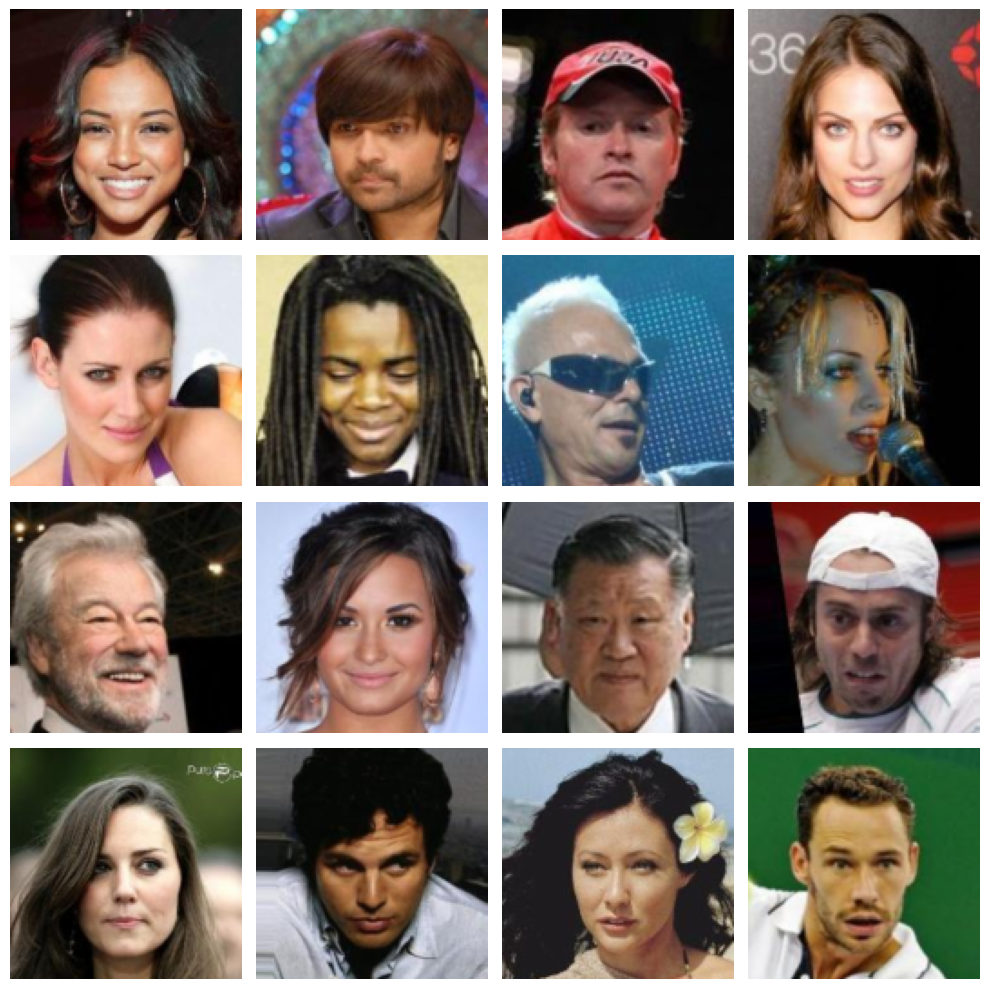

In [11]:
# Check a batch of images
batch = next(iter(loader))
print(f"Batch shape: {batch.shape}")  # Should be [128, 3, 128, 128]

# Plot the first 16 images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()
for i, ax in enumerate(axes):
    img = batch[i]
    img = img * 0.5 + 0.5
    img = img.permute(1, 2, 0).cpu().numpy()
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device being used: {device}')

vgg = models.vgg16(pretrained=True).features[:9].eval().to(device)
for p in vgg.parameters():
    p.requires_grad = False

def perceptual_loss(x, y):
    fx = vgg(x)
    fy = vgg(y)
    return F.mse_loss(fx, fy)

Device being used: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 68.8MB/s]


In [19]:

os.makedirs("results/vae", exist_ok=True)
os.makedirs("models/vae", exist_ok=True)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(channels,16,4,2,1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Conv2d(16,32,4,2,1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,64,4,2,1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128,256,4,2,1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)


        self.decoder_fc = nn.Linear(latent_dim, 256*4*4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,2,1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32,16,4,2,1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.ConvTranspose2d(16,channels,4,2,1), nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 256, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, epoch):
    mse = F.mse_loss(recon_x, x, reduction='sum')
    perc = perceptual_loss(recon_x, x) * x.numel()
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + perc + kld, mse, perc, kld

In [20]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [29]:
def train(epoch, model, dataloader, optimizer, device):
    """
    Train the model.
    """
    model.train()

    train_loss = 0
    recon_loss = 0
    perc_loss = 0
    regul_loss = 0

    pbar = tqdm(dataloader)

    for batch_idx, data in enumerate(pbar):

        data = data.to(device)

        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)

        loss_batch, recon_loss_batch, perc_loss_batch, regul_loss_batch = loss_function(recon_batch, data, mu, logvar, epoch)

        loss_batch.backward()

        train_loss += loss_batch.item()
        recon_loss += recon_loss_batch.item()
        perc_loss += perc_loss_batch.item()
        regul_loss += regul_loss_batch.item()


        optimizer.step()

        pbar.set_description(f'Epoch: {epoch} Loss: {loss_batch.item():.4f} Recon Loss: {recon_loss_batch.item():.4f} Perc Loss: {perc_loss_batch.item():.4f}  Regul Loss: {regul_loss_batch.item():.4f}')

    scheduler.step()

    train_loss /= len(dataloader)
    recon_loss /= len(dataloader)
    perc_loss /= len(dataloader)
    regul_loss /= len(dataloader)

    return train_loss, recon_loss, perc_loss, regul_loss


def generate_samples(epoch):
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample, f'results/vae/sample_{epoch}.png', nrow=8, normalize=True)

In [ ]:
train_loss_all = []
recon_loss_all = []
regul_loss_all = []

for epoch in range(1, epochs + 1):

    train_loss, recon_loss, perc_loss, regul_loss = train(epoch, model, loader, optimizer, device)

    print(f'Epoch: {epoch}, Loss: {train_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Div: {regul_loss:.4f}')

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'models/vae/ff q_vae_epoch_{epoch}.pth')

    train_loss_all.append(train_loss)
    recon_loss_all.append(recon_loss)
    regul_loss_all.append(regul_loss)

torch.save(model.state_dict(), 'models/vae/ffhq_vae_final.pth')